<a href="https://colab.research.google.com/github/Bushra1216/AI-Image-Generation-/blob/main/AI_Image_Generation_with_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DCGAN Model

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] ='/content'

In [ ]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.31G/1.33G [00:11<00:00, 109MB/s] 
100% 1.33G/1.33G [00:11<00:00, 120MB/s]


In [ ]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197604.jpg  
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torchvision.utils as vutils

import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [ ]:
CUDA_DEVICE_NUM = 2
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:2


In [ ]:
# The directory path where dataset is located
DATA_DIR = "/content/img_align_celeba"

### Hyperparamaters
# Batch size is the number of samples processed in each iteration during training
batch_size = 1024

# Spatial size of training images, the images will be resized on that size
image_size = 64

# The number of image channels (e.g., 3 for RGB)
CHANNELS = 3

# Latent vector z , input vector to the generator
INPUT_VECTOR_DIM = 100

# The initial number of feature maps in the generator and discriminator
FEATURE_MAP_DIM = 64

# Learning rate for optimizers , 2e-4 is equal to 0.0002
LR = 2e-4

# Beta1 parameter for Adam optimizer
BETA1 = 0.5

# number of training iteration
EPOCHS = 15

# Used to ensure the sequence of random numbers generated will be same when each time the program run with that specific seed
RANDOM_SEED = 42

# to ensure the reproducable result
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


device = "cuda" if torch.cuda.is_available() else "cpu"
print('Device:', device)


Device: cuda


In [ ]:
dataset = ImageFolder(DATA_DIR,
                           transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize(*((0.5,0.5,0.5),(0.5,0.5,0.5))),
                           ]))


dataloader = DataLoader(dataset, BATCH_SIZE, shuffle=True)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, feature_map_dim, channels):
        super(Discriminator, self).__init__()
        self.conv_1 = nn.Conv2d(channels, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.conv_2 = nn.Conv2d(feature_map_dim*2, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.conv_3 = nn.Conv2d(feature_map_dim*4, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.conv_4 = nn.Conv2d(feature_map_dim*8, feature_map_dim*16, 4, 2, 1, bias=False) #size [1024, 4, 4]
        self.conv_5 = nn.Conv2d(feature_map_dim*16, 1, 4, 1, 0, bias=False) #size [1, 1, 1]

        self.leaky_relu = nn.LeakyReLU(0.2)

        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*16)
        self.sigmoid = nn.Sigmoid()


    def forward(self, inp):
        x = self.conv_1(inp)
        x = self.leaky_relu(x)

        x = self.conv_2(x)
        x = self.batch_norm_1(x)
        x = self.leaky_relu(x)

        x = self.conv_3(x)
        x = self.batch_norm_2(x)
        x = self.leaky_relu(x)

        x = self.conv_4(x)
        x = self.batch_norm_3(x)
        x = self.leaky_relu(x)

        x = self.conv_5(x)
        out = self.sigmoid(x)

        return out

In [ ]:
discriminator = Discriminator(FEATURE_MAP_DIM, CHANNELS).to(device)

x = torch.randn(BATCH_SIZE, CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
dis_out = discriminator(x)
print(dis_out.size())

torch.Size([1024, 1, 1, 1])


In [ ]:
class Generator(nn.Module):
    def __init__(self, input_vector_dim, feature_map_dim, channels):
        super(Generator, self).__init__()
        self.convt_1 = nn.ConvTranspose2d(input_vector_dim, feature_map_dim*16, 4, 1, 0, bias=False) #size [1024, 4, 4]
        self.convt_2 = nn.ConvTranspose2d(feature_map_dim*16, feature_map_dim*8, 4, 2, 1, bias=False) #size [512, 8, 8]
        self.convt_3 = nn.ConvTranspose2d(feature_map_dim*8, feature_map_dim*4, 4, 2, 1, bias=False) #size [256, 16, 16]
        self.convt_4 = nn.ConvTranspose2d(feature_map_dim*4, feature_map_dim*2, 4, 2, 1, bias=False) #size [128, 32, 32]
        self.convt_5 = nn.ConvTranspose2d(feature_map_dim*2, channels, 4, 2, 1, bias=False) #size [3, 64, 64]

        self.relu = nn.ReLU()

        self.batch_norm_1 = nn.BatchNorm2d(feature_map_dim*16)
        self.batch_norm_2 = nn.BatchNorm2d(feature_map_dim*8)
        self.batch_norm_3 = nn.BatchNorm2d(feature_map_dim*4)
        self.batch_norm_4 = nn.BatchNorm2d(feature_map_dim*2)

        self.tanh = nn.Tanh()

    def forward(self, inp):
        x = self.convt_1(inp)
        x = self.batch_norm_1(x)
        x = self.relu(x)

        x = self.convt_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)

        x = self.convt_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)

        x = self.convt_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)

        x = self.convt_5(x)
        out = self.tanh(x)

        return out

In [ ]:
generator = Generator(INPUT_VECTOR_DIM, FEATURE_MAP_DIM, CHANNELS).to(device)

noise = torch.randn(BATCH_SIZE, INPUT_VECTOR_DIM, 1, 1, device=device)
gen_out = generator(noise)
print(gen_out.size())


torch.Size([1024, 3, 64, 64])


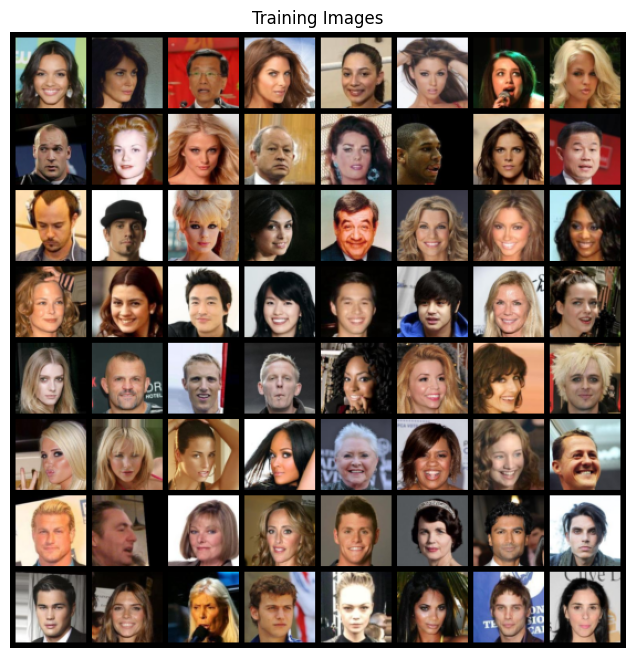

In [ ]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

100%|██████████| 198/198 [23:48<00:00,  7.22s/it]


Discriminator Loss EPOCH 1: 20195.5161
Generator Loss EPOCH 1: 6.3340


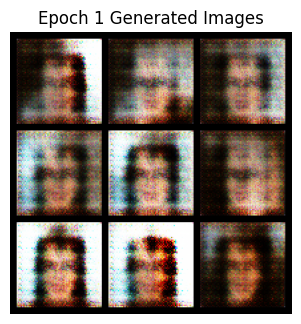

100%|██████████| 198/198 [23:54<00:00,  7.24s/it]


Discriminator Loss EPOCH 2: 22079.1526
Generator Loss EPOCH 2: 2.3272


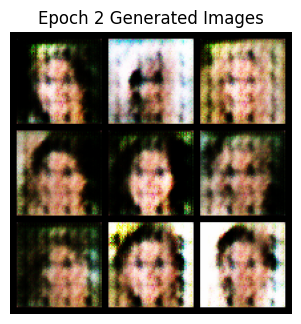

100%|██████████| 198/198 [23:56<00:00,  7.25s/it]


Discriminator Loss EPOCH 3: 20534.0764
Generator Loss EPOCH 3: 2.7325


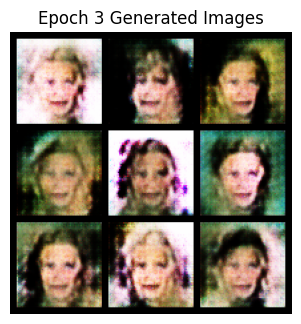

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 4: 18396.3424
Generator Loss EPOCH 4: 3.0887


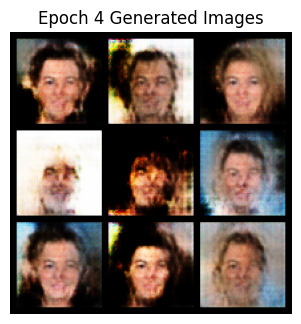

100%|██████████| 198/198 [23:54<00:00,  7.24s/it]


Discriminator Loss EPOCH 5: 17513.6657
Generator Loss EPOCH 5: 3.2555


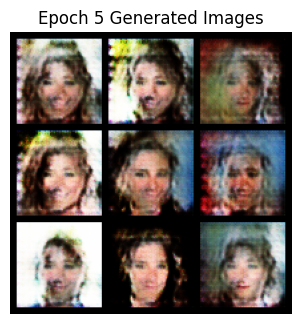

100%|██████████| 198/198 [23:54<00:00,  7.25s/it]


Discriminator Loss EPOCH 6: 17157.5527
Generator Loss EPOCH 6: 3.3609


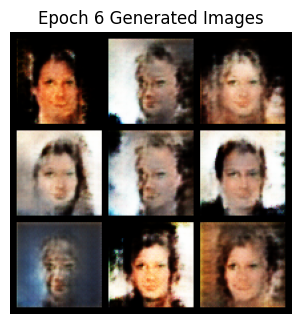

100%|██████████| 198/198 [23:56<00:00,  7.25s/it]


Discriminator Loss EPOCH 7: 17963.0766
Generator Loss EPOCH 7: 3.0854


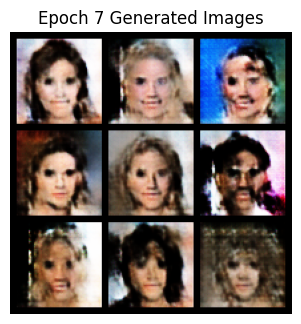

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 8: 17283.1010
Generator Loss EPOCH 8: 3.0764


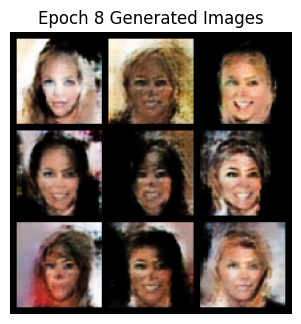

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 9: 15807.9938
Generator Loss EPOCH 9: 3.3722


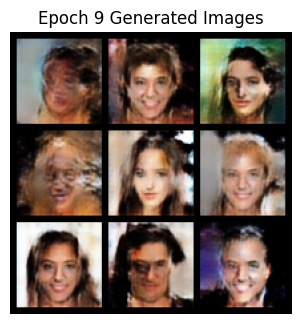

100%|██████████| 198/198 [24:01<00:00,  7.28s/it]


Discriminator Loss EPOCH 10: 14915.6178
Generator Loss EPOCH 10: 3.2928


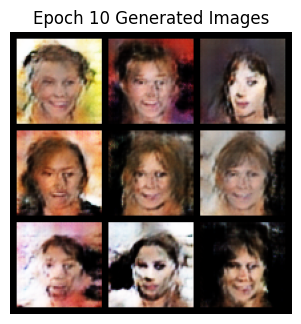

100%|██████████| 198/198 [23:59<00:00,  7.27s/it]


Discriminator Loss EPOCH 11: 13923.2159
Generator Loss EPOCH 11: 3.4015


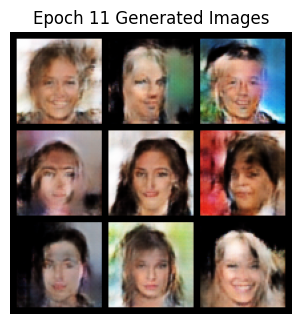

100%|██████████| 198/198 [23:58<00:00,  7.26s/it]


Discriminator Loss EPOCH 12: 13636.0551
Generator Loss EPOCH 12: 3.5301


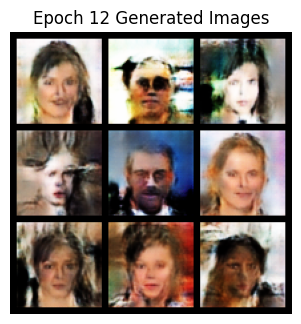

100%|██████████| 198/198 [23:58<00:00,  7.27s/it]


Discriminator Loss EPOCH 13: 12911.5331
Generator Loss EPOCH 13: 3.5851


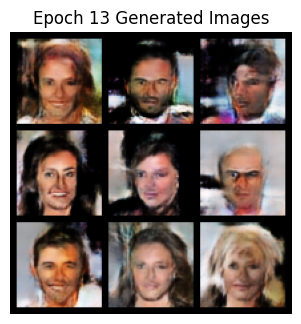

100%|██████████| 198/198 [23:56<00:00,  7.25s/it]


Discriminator Loss EPOCH 14: 12963.4694
Generator Loss EPOCH 14: 3.5436


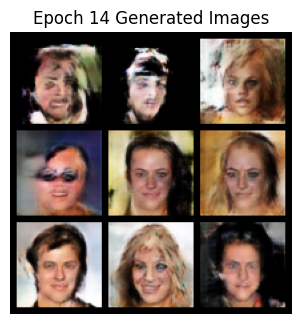

100%|██████████| 198/198 [23:53<00:00,  7.24s/it]


Discriminator Loss EPOCH 15: 12736.9993
Generator Loss EPOCH 15: 3.6225


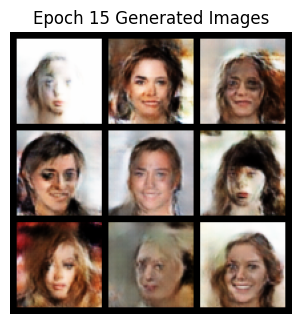

100%|██████████| 15/15 [5:59:41<00:00, 1438.78s/it]

Training Time: 21581.69s


In [ ]:
generator_losses = []
discriminator_losses = []

criterion = nn.BCELoss()

discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, 0.999))

generator.train()
discriminator.train()

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    generator_running_loss = 0
    discriminator_running_loss = 0
    for idx, data in enumerate(tqdm(dataloader, position=0, leave=True)):
        img_data = data[0].to(device)  # size [1024, 3, 64, 64]
        dummy_labels = data[1]  # size [1024]

        real_labels = torch.full((dummy_labels.size()), 1., dtype=torch.float).to(device)  # size [1024]
        fake_labels = torch.full((dummy_labels.size()), 0., dtype=torch.float).to(device)
        noise = torch.randn(dummy_labels.size()[0], INPUT_VECTOR_DIM, 1, 1).to(device)  # size [1024, 100, 1, 1]

        discriminator_real_out = discriminator(img_data).view(-1)  # size [1024] .view(-1) to rid unnecessary dimensions
        discriminator_real_loss = criterion(discriminator_real_out, real_labels)
        discriminator.zero_grad()
        discriminator_real_loss.backward()

        generator_fake_out = generator(noise)  # size [1024, 3, 64, 64]
        discriminator_fake_out = discriminator(generator_fake_out.detach()).view(-1)  # detach used because we'll calculate it for a second time
        discriminator_fake_loss = criterion(discriminator_fake_out, fake_labels)
        discriminator_fake_loss.backward()
        discriminator_running_loss += discriminator_real_loss.item() + discriminator_fake_loss.item()
        # Update Discriminator.......
        discriminator_optimizer.step()

        discriminator_fake_out = discriminator(generator_fake_out).view(-1)  # calculated it for a second time. So that we won't have to backward graphs a second time
        generator_loss = criterion(discriminator_fake_out, real_labels)
        generator_running_loss += generator_loss.item()
        generator.zero_grad()
        generator_loss.backward()
        # Update Generator......................
        generator_optimizer.step()

    discriminator_loss = discriminator_running_loss / 2 * (idx + 1)
    generator_loss = generator_running_loss / (idx + 1)

    discriminator_losses.append(discriminator_loss)
    generator_losses.append(generator_loss)

    print(f"Discriminator Loss EPOCH {epoch+1}: {discriminator_loss:.4f}")
    print(f"Generator Loss EPOCH {epoch+1}: {generator_loss:.4f}")
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.title(f"Epoch {epoch+1} Generated Images")
    plt.imshow(np.transpose(vutils.make_grid(generator_fake_out[:9], padding=5, normalize=True, nrow=3).cpu(), (1, 2, 0)))
    plt.show()

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

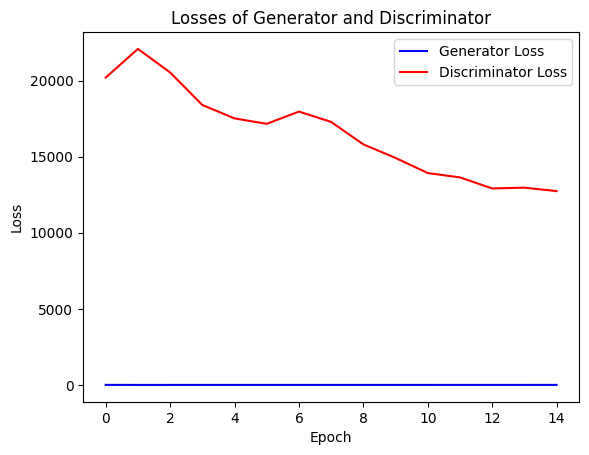

In [ ]:
import matplotlib.pyplot as plt
# Plot the loss curves

plt.plot(generator_losses, label='Generator Loss', color='blue')
plt.plot(discriminator_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Losses of Generator and Discriminator')
plt.show()

GAN model


In [ ]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import os

DATA_DIR = '/content/img_align_celeba'

In [ ]:
DATA_DIR = "/kaggle/input/celeba-dataset"

image_size = 64
batch_size = 1024
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(root=DATA_DIR,
                       transform=T.Compose([T.Resize(image_size),
                                            T.CenterCrop(image_size), # pick central square crop of it
                                            T.ToTensor(),
                                            T.Normalize(*stats)        # normalize => -1 to 1
                                        ]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True) # use multiple cores

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=9):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=3).permute(1, 2, 0))

def show_batch(dl, nmax=9):
  for images, _ in dl:
    show_images(images, nmax)
    break

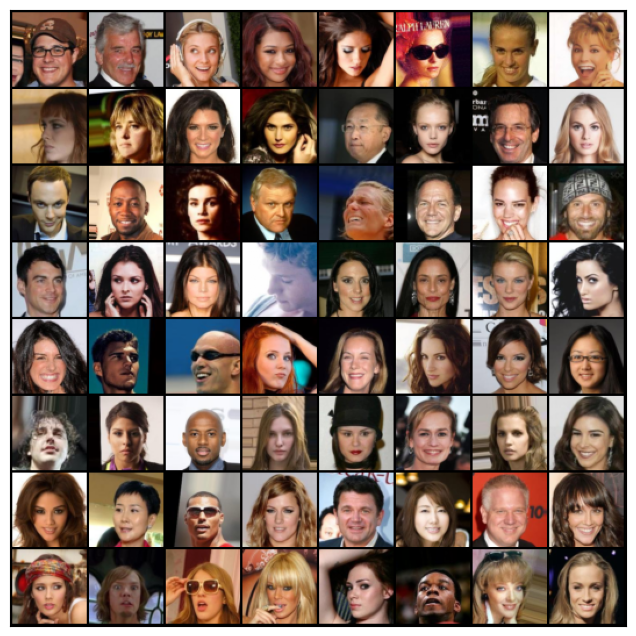

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)


In [ ]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
discriminator = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device)
for layer in discriminator:
    X = layer(X)

latent_size = 100

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

X = torch.randn(size=(1, latent_size, 1, 1))  # Adjust the size based on latent_size
for layer in generator:
    X = layer(X)



In [ ]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


torch.Size([128, 3, 64, 64])


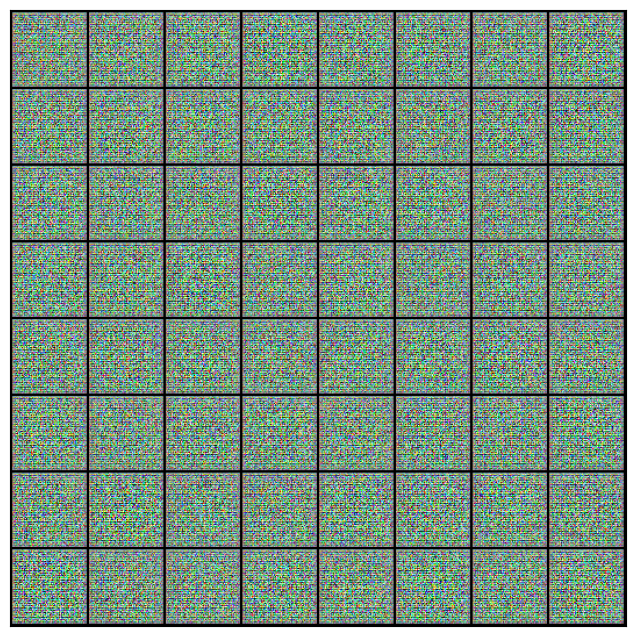

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device) # move generator to device

In [ ]:
def train_discriminator(real_images, opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()

  # Pass real images through  discriminator
  real_preds = discriminator(real_images)
  real_targets = torch.ones(real_images.size(0), 1, device=device)
  real_loss = F.binary_cross_entropy(real_preds, real_targets)
  real_score = torch.mean(real_preds).item()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = generator(latent)

  # Pass Fake images through discriminator
  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score = torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
  # Clear generator gradients
  opt_g.zero_grad()

  # Generate fake images
  latent = torch.randn(batch_size, latent_size, 1,1, device=device)
  fake_images = generator(latent)

  # Try to fool the discriminator
  preds = discriminator(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = F.binary_cross_entropy(preds, targets)

  # Update generator
  loss.backward()
  opt_g.step()

  return loss.item()

In [ ]:
import os
from torchvision.utils import save_image

sample_dir = 'generatedImages'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
  fake_images = generator(latent_tensors)
  fake_fname = 'Generated-image-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=3)
  print("Saving", fake_fname)

  if show:
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=3).permute(1, 2, 0))

In [ ]:
from torchvision.utils import save_image

In [ ]:
fixed_latent = torch.randn(9, latent_size, 1, 1, device=device)

Saving generated=images-0000.png


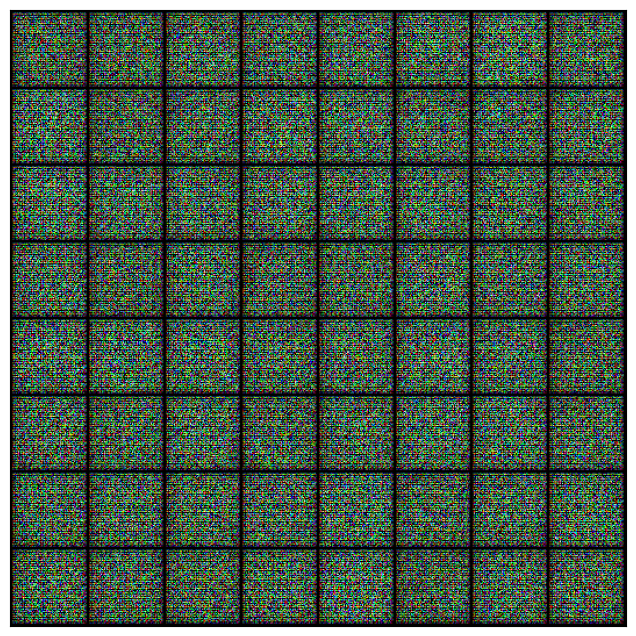

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx = 1):
  torch.cuda.empty_cache()

  # Losses & scores
  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  # Create optimizers
  opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
  opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      # Train discriminator
      loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
      # Train generator
      loss_g = train_generator(opt_g)

    # Record losses & scores
    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    # Log losses & scores (last batch)
    print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    # Save generated images
    save_samples(epoch+start_idx, fixed_latent, show=False)

  return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 2e-4
epochs = 17

In [ ]:
history = fit(epochs, lr)

  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [1/5], loss_g: 2.8383, loss_d: 0.5480, real_score: 0.6734, fake_score: 0.0819
Saving generated=images-0001.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [2/5], loss_g: 5.7370, loss_d: 0.5751, real_score: 0.9610, fake_score: 0.3771
Saving generated=images-0002.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [3/5], loss_g: 2.5433, loss_d: 0.2259, real_score: 0.8507, fake_score: 0.0386
Saving generated=images-0003.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [4/5], loss_g: 2.4018, loss_d: 0.5401, real_score: 0.6707, fake_score: 0.0386
Saving generated=images-0004.png


  0%|          | 0/1583 [00:00<?, ?it/s]

Epoch [5/5], loss_g: 9.2241, loss_d: 0.9932, real_score: 0.9937, fake_score: 0.5491
Saving generated=images-0005.png


In [ ]:
# Save the model checkpoints
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
from IPython.display import Image

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generatedImages/Generated-image-0001.png')

![epoch 1.png](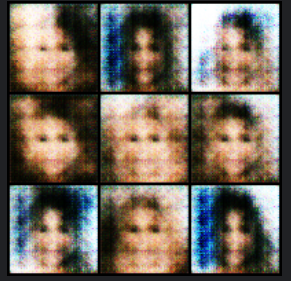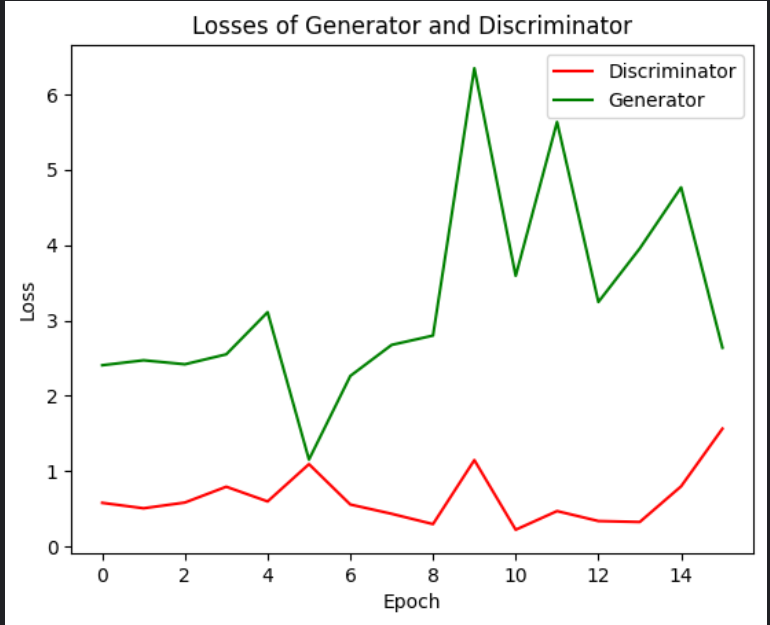)

In [ ]:
Image('./generateImages/generated=images-0015.png')

In [ ]:
import cv2
import os

vid_fname = 'gans_training.avi'


files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()



fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fname,fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

In [ ]:
import matplotlib.pyplot as plt



plt.plot(losses_d, color='red', label='Discriminator')
plt.plot(losses_g, color='green', label='Generator')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses of Generator and Discriminator')

plt.show()